## Import Modules

In [1]:
# Core
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from pyclustering.cluster.kmedoids import kmedoids


# Text Processing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import wordcloud
from textblob import TextBlob
from nltk.corpus import stopwords
import nltk.collocations as nc
import spacy
nlp = spacy.load('en_core_web_sm')
# Remove stopwords, including google and tesla
stops = stopwords.words('english') + ['google', 'tesla', 'work']
en_stopwords = set(stops)
from textblob import TextBlob
from sklearn.decomposition import NMF, LatentDirichletAllocation

# Time Series
import seaborn as sns
sns.set(style="ticks", color_codes=True)

# Geo
import folium
import os

# Machine Learning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from pyclustering.cluster.silhouette import silhouette_ksearch_type, silhouette_ksearch
import operator



## Import Datasets 
#### (Google & Tesla reviews web-scraped from Indeed)

In [2]:
# Import datasets - web scraped data

# Code Source 
# https://stackoverflow.com/questions/16888888/how-to-read-a-xlsx-file-
# using-the-pandas-library-in-ipython

df_google = pd.read_excel('google_reviews.xlsx', sheet_name="sheet1")
df_tesla = pd.read_excel('tesla_reviews.xlsx', sheet_name="sheet1")

# Import state data for geo

# Code Source 
# https://developers.google.com/public-data/docs/canonical/states_csv
df_state_geo = pd.read_csv('states_geo.csv')

## EDA & Data Cleaning

In [3]:
# Get some information about the datasets

# Code Source
# https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial

df_google.info()
df_tesla.info()

# No missing values - all objects, one float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1329 entries, 0 to 1328
Data columns (total 6 columns):
title       1326 non-null object
reviewer    1329 non-null object
location    1329 non-null object
date        1329 non-null object
rating      1329 non-null float64
reviews     1329 non-null object
dtypes: float64(1), object(5)
memory usage: 62.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 6 columns):
title       1233 non-null object
reviewer    1235 non-null object
location    1235 non-null object
date        1235 non-null object
rating      1235 non-null float64
reviews     1235 non-null object
dtypes: float64(1), object(5)
memory usage: 58.0+ KB


####  Convert data types

In [4]:
# Code Source
# https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial

# Date to date data type
df_google.date = pd.to_datetime(df_google.date)
df_tesla.date = pd.to_datetime(df_tesla.date)

# Rating to integer
df_google.rating = df_google.rating.astype(np.int64)
df_tesla.rating = df_tesla.rating.astype(np.int64)

In [5]:
# Take a look at the google dataframe
df_google.head(2)

,title,reviewer,location,date,rating,reviews
0,Awesome,Camp Counselor (Former Employee) –,"Northborough, MA",2018-01-17,5,Awesome stuff at google if I had to rate it fr...
1,Google is great Bon Apeptit isn’t so great!,Micro kitchen attendant (Former Employee) –,"Mountain View, CA",2018-08-24,5,Google is a great company and the googler were...


In [6]:
# Take a look at the tesla dataframe
df_tesla.head(2)

,title,reviewer,location,date,rating,reviews
0,Stressful,PV Design Engineer II (Current Employee) –,"Westborough, MA",2018-06-14,3,Very tight Schedule.Get to learn a little.Aver...
1,Looks good on the resume,Service Advisor (Former Employee) –,"Burbank, CA",2019-01-16,3,Tesla asks if you're okay with overtime but yo...



#### Create employee type (former or current employee) from reviewer variable

In [7]:
# Strip out former/current employee and make it's own variable

# Code Source: 
# https://www.geeksforgeeks.org/python-pandas-split-strings-into-two-list-columns-using-str-split/

# split reviewer variable on '(' 
new_google = df_google["reviewer"].str.split("(", n = 1, expand = True) 
new_tesla = df_tesla["reviewer"].str.split("(", n = 1, expand = True) 

# make job title column from the left part of the split 
df_google["job_title"]= new_google[0] 
df_tesla["job_title"]= new_tesla[0] 
  
# make emp type column from the right part of the split
df_google["emp_status"]= new_google[1] 
df_tesla["emp_status"]= new_tesla[1] 

# Drop reviewer column 
df_google.drop('reviewer', inplace=True, axis=1)
df_tesla.drop('reviewer', inplace=True, axis=1) 

In [8]:
# Now have 7 variables, created employee type & job title, dropped reviewer
df_google.shape

(1329, 7)

In [9]:
df_tesla.shape

(1235, 7)

In [10]:
# Get a count of each employee status category

# Code Source
# https://stackoverflow.com/questions/22391433/count-the-frequency
# -that-a-value-occurs-in-a-dataframe-column

df_google['emp_status'].value_counts()

# Lots of junk in there

Former Employee) –                                                     826
Current Employee) –                                                    454
Contract) (Former Employee) –                                           12
Contractor) (Former Employee) –                                          6
contract) (Current Employee) –                                           2
Contract) (Current Employee) –                                           2
ITRP) (Current Employee) –                                               1
ETouch) (Former Employee) –                                              1
Tier 1) (Current Employee) –                                             1
Seasonal) (Former Employee) –                                            1
Business Applications) (Current Employee) –                              1
LCS), Big Box Vertical (Former Employee) –                               1
Fixed-Term) (Former Employee) –                                          1
contractor) (Former Emplo

In [11]:
df_tesla['emp_status'].value_counts()

Former Employee) –                                     728
Current Employee) –                                    490
Temp) (Former Employee) –                                2
Full-time) (Current Employee) –                          1
Mechanical Joining) (Current Employee) –                 1
Paint) (Former Employee) –                               1
contract) (Former Employee) –                            1
Swing Shift) (Former Employee) –                         1
SEASONAL) (Former Employee) –                            1
 Lead-Davie) (Former Employee) –                         1
Production Control /Model 3) (Current Employee) –        1
Supply Chain Programs (Current Employee) –               1
Automation) (Former Employee) –                          1
Powertrain Conveyance) (Current Employee) –              1
PLM) Program Manager (Former Employee) –                 1
Contract) (Former Employee) –                            1
CDL) (Current Employee) –                               

In [12]:
# Pretty much an if statement - if emp_status contains 'Current', make it 'current', else make it 'former'

# Code Source
# https://stackoverflow.com/questions/18196203/
# how-to-conditionally-update-dataframe-column-in-pandas

df_google['emp_status'] = np.where(df_google['emp_status'].str.contains('Current'), 'current', 'former')

df_tesla['emp_status'] = np.where(df_tesla['emp_status'].str.contains('Current'), 'current', 'former')

In [13]:
# Clean categories - current/former
df_google['emp_status'].value_counts()

former     863
current    466
Name: emp_status, dtype: int64

In [14]:
df_tesla['emp_status'].value_counts()

former     738
current    497
Name: emp_status, dtype: int64

#### Create state from location variable

In [15]:
# Strip out state and make it's own variable

# split location variable on ',' 
new_google = df_google["location"].str.split(",", n = 1, expand = True) 
new_tesla = df_tesla["location"].str.split(",", n = 1, expand = True) 

# make state column from the right part of the split 
df_google["state"]= new_google[1] 
df_tesla["state"]= new_tesla[1] 

# Drop location column 
df_google.drop('location', inplace=True, axis=1)
df_tesla.drop('location', inplace=True, axis=1) 

In [16]:
# Take the first two characters

# Code Source
# https://stackoverflow.com/questions/36505847/substring-of-an-entire-column-in-pandas-dataframe

df_google.state = df_google.state.str.slice(1, 3)
df_tesla.state = df_tesla.state.str.slice(1, 3)

In [17]:
# Upper case the state code extracted

# Code Source
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.upper.html

df_google.state = df_google.state.str.upper()
df_tesla.state = df_tesla.state.str.upper()

In [18]:
# Get a count of each employee status category
df_google['state'].value_counts()

CA    629
NY    117
WA     58
TX     48
GA     41
MI     36
IL     30
MA     26
PA     21
FL     19
AZ     18
NC     16
MO     16
DC     12
CO     12
IA     11
UT      9
OR      9
SC      6
NJ      4
NM      4
NV      4
TN      3
ID      3
WI      3
KS      3
MD      3
AL      3
IN      2
        2
OH      2
VA      2
OK      2
PR      1
A.      1
MS      1
AR      1
ES      1
NH      1
VT      1
A       1
D       1
CT      1
AS      1
CE      1
E       1
DA      1
Name: state, dtype: int64

In [19]:
# Validate states extracted against state list,
# Not found assign ERR

# Code Source
# https://thispointer.com/python-how-to-check-if-an-item-exists-in-list-search-by-value-or-condition/

def state_lookup(df):
    # If valid state code, keep it, else assign 'ERR'
    for i in range(0,len(df)):
        if df.iloc[i] in df_state_geo['state'].values.tolist():
            df[i] = df[i]
        else:
            df[i] = 'ERR'
        

In [20]:
state_lookup(df_google.state)

/Users/christiandavies/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/christiandavies/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [21]:
state_lookup(df_tesla.state)

/Users/christiandavies/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/christiandavies/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [22]:
# Get a count of reviews in each state
df_google['state'].value_counts()

CA     629
ERR    151
NY     117
WA      58
TX      48
GA      41
MI      36
IL      30
MA      26
PA      21
FL      19
AZ      18
MO      16
NC      16
DC      12
CO      12
IA      11
OR       9
UT       9
SC       6
NJ       4
NM       4
NV       4
AL       3
TN       3
KS       3
MD       3
ID       3
WI       3
VA       2
OH       2
OK       2
IN       2
PR       1
MS       1
VT       1
CT       1
NH       1
AR       1
Name: state, dtype: int64

In [23]:
# Get a count of reviews in each state
df_tesla['state'].value_counts()

CA     784
NV     175
ERR     81
TX      32
NY      20
UT      18
CO      14
FL      12
MD      10
MA       9
NJ       8
PA       8
OH       7
NC       6
DE       5
AZ       5
VA       4
WA       4
CT       4
OR       3
HI       3
GA       3
VT       3
MN       2
MI       2
NM       2
IL       2
ND       1
ID       1
OK       1
LA       1
IN       1
NE       1
KS       1
TN       1
AK       1
Name: state, dtype: int64

In [24]:
# Merge longitude/latitude to dataframe, may use later for geo

# Code source
# https://medium.com/importexcel/common-excel-task-
# in-python-vlookup-with-pandas-merge-c99d4e108988

df_google = pd.merge(df_google,df_state_geo, how='left', on='state')
df_tesla = pd.merge(df_tesla, df_state_geo, how='left', on='state')


In [25]:
# Assign company variable
df_google['Company'] = 'google'
df_tesla['Company'] = 'tesla'

In [26]:
# Union google and tesla datasets for bar chart

# Code Source
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

frames = [df_google, df_tesla]

df_comp = pd.concat(frames)

In [27]:
# Change data type for categorical variables

# Code source
# https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html

df_comp['emp_status'] = df_comp['emp_status'].astype('category')
df_comp['Company'] = df_comp['Company'].astype('category')
df_comp['state'] = df_comp['state'].astype('category')

#### Explore newly created employee status variable

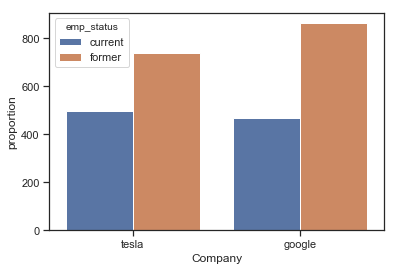

In [28]:
# Barplot - Percentage of reviews by current/former empployees

# Code sournce
# https://stackoverflow.com/questions/35692781/python-plotting-percentage-in-seaborn-bar-plot

x, y, hue = "Company", "proportion", "emp_status"
# hue_order = ["Male", "Female"]

(df_comp[x]
 .groupby(df_comp[hue])
 .value_counts()
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue));

#### Explore rating variable

In [29]:
# Look at Rating Summary for Google
df_google['rating'].describe()

count    1329.000000
mean        4.221971
std         0.999065
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

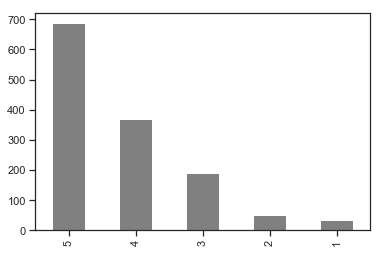

In [30]:
# Rating Frequency Bar Plot Google
df_google['rating'].value_counts().plot.bar(color='Gray');

In [31]:
# Look at Rating Summary for Tesla
df_tesla['rating'].describe()

count    1235.000000
mean        3.587854
std         1.277285
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

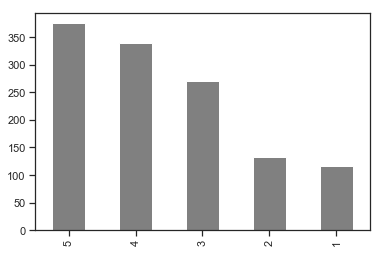

In [32]:
# Rating Frequency Bar Plot Google
df_tesla['rating'].value_counts().plot.bar(color='Gray');

#### Explore state variable

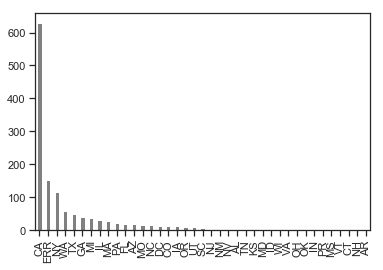

In [33]:
# State Frequency Bar Plot Google
df_google['state'].value_counts().plot.bar(color='Gray');

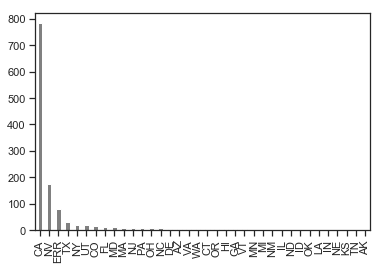

In [34]:
# State Frequency Bar Plot Google
df_tesla['state'].value_counts().plot.bar(color='Gray');

#### TF-IDF


In [35]:
# Combine title and reviews to clean for each review
# Trying to not combine -  many titles were duped in review
# google_review_text = df_google["title"] + ' ' + df_google["reviews"]
# tesla_review_text = df_tesla["title"] + ' ' + df_tesla["reviews"]

google_review_text = df_google["reviews"]
tesla_review_text = df_tesla["reviews"]

In [36]:
# Take a closer look at combine review text
google_review_text[1]

'Google is a great company and the googler were awesome, knowledgeable and open to teaching. It was the company I was contacted with Bon Apeptit that was terrible the management was u professional much like being on highschool. Not much room for advancement unless you were related to someone that worked there. I worked there for a year only revived a 2% increase in my raise so after a year in a half I was at 15.30. I felt like I was treated poorly by management there. As well as my health and safety while working was put at risk'

In [37]:
tesla_review_text[1]

"Tesla asks if you're okay with overtime but you don't realize you're giving up all your personal time. As a service advisor, you start your day writing tickets and interacting with customers. Throughout the day, you need to keep up with updating customers three times a day while stuck on the drive. Management sets expectations that aren't feasible and focus on the customer service index that you don't always have control over (the customers not filling out the survey or deleting them). It was difficult to balance the work load and a personal life with the amount of time it takes to keep customers in the loop."

In [38]:
# Function to clean text

# Parts of code from Week 3 and Week 6 Solutions
# Regis Text Analytics Class - Dr. Nathan George

def preprocess_text(text_docs):
   
    # remove punctuation
    table = str.maketrans({key: None for key in string.punctuation})
    docs = [str(d).translate(table) for d in text_docs]
    # replace newlines with spaces
    docs = [re.sub('[\r\n]+', ' ', d) for d in docs]
    # replace website links with space -- want to do this before digits
    docs = [re.sub('https[\w]*', ' ', d) for d in docs]
    # replace digits with space
    docs = [re.sub('\d', ' ', d) for d in docs]
    # relpace multiple spaces with one
    docs = [re.sub('\s\s+', ' ', d) for d in docs]
    
    
    # process with spacy
    spacy_docs = [nlp(d) for d in docs]
    lemmatized_docs = []
    
    # keep the word if it's a pronoun, otherwise use the lemma
    lemmas = [[w.lemma_ if w.lemma_ != '-PRON-'
                   else w.lower_
                   for w in d if w.lower_ not in en_stopwords]
              for d in spacy_docs]
    
    
    pos = [[w.pos_ for w in d if w.lower_ not in en_stopwords] for d in spacy_docs]
    flat_lemmas = [i for l in lemmas for i in l]
    flat_pos = [i for p in pos for i in p]
    df = pd.DataFrame({'word': flat_lemmas, 'pos': flat_pos})
    
    lemmatized_docs = [' '.join(l) for l in lemmas]
    
    return lemmatized_docs, df

In [39]:
# Run preprocess_text for reviews
cln_review_google, df_pos_google = preprocess_text(google_review_text)
cln_review_tesla, df_pos_tesla = preprocess_text(tesla_review_text)

In [40]:
# Take a closer look at cleaned review
cln_review_google[1]

'great company googler awesome knowledgeable open teach company contact bon apeptit terrible management u professional much like highschool much room advancement unless relate someone work work year revive increase raise year half feel like treat poorly management well health safety work put risk'

In [42]:
cln_review_tesla[1]

'ask okay overtime not realize give personal time service advisor start day write ticket interact customer throughout day need keep update customer three time day stick drive management set expectation not feasible focus customer service index not always control customer fill survey delete difficult balance load personal life amount time take keep customer loop'

In [43]:
# Create lists of grouped words - part of speech, word

# Code Source
# From Text Analytics Week 3 - Dr. Nathan George

words_google = list(df_pos_google.groupby('word'))
words_tesla = list(df_pos_tesla.groupby('word'))

In [44]:
# Gets value counts of words - word, pos, count

# From Text Analytics Week 3 - Dr. Nathan George

all_cnts_google = {}
for w, w_df in words_google:
    all_cnts_google[w] = w_df['pos'].value_counts()
    
all_cnts_tesla = {}
for w, w_df in words_tesla:
    all_cnts_tesla[w] = w_df['pos'].value_counts()

In [45]:
# Total up nouns and verbs

# From Text Analytics Week 3 - Dr. Nathan George

nouns_google, verbs_google = {}, {}
for w in all_cnts_google:
    if 'NOUN' in all_cnts_google[w].keys():
        nouns_google[w] = all_cnts_google[w]['NOUN']
    
    if 'VERB' in all_cnts_google[w].keys():
        verbs_google[w] = all_cnts_google[w]['VERB']
        
        
nouns_tesla, verbs_tesla = {}, {}
for w in all_cnts_tesla:
    if 'NOUN' in all_cnts_tesla[w].keys():
        nouns_tesla[w] = all_cnts_tesla[w]['NOUN']
    
    if 'VERB' in all_cnts_tesla[w].keys():
        verbs_tesla[w] = all_cnts_tesla[w]['VERB']

In [46]:
# Report out top 10 nouns and verbs per company

# Code Source from Week 3 Text Analytics - Dr. Nathan George
# https://stackoverflow.com/questions/613183/how-to-sort-a-dictionary-by-value

# Sorting most nouns/verbs to the least
top_nouns_google = sorted(nouns_google, key=nouns_google.get, reverse=True)
top_noun_counts_google = [nouns_google[n] for n in top_nouns_google]
top_verbs_google = sorted(verbs_google, key=verbs_google.get, reverse=True)
top_verb_counts_google = [verbs_google[v] for v in top_verbs_google]

top_nouns_tesla = sorted(nouns_tesla, key=nouns_tesla.get, reverse=True)
top_noun_counts_tesla = [nouns_tesla[n] for n in top_nouns_tesla]
top_verbs_tesla = sorted(verbs_tesla, key=verbs_tesla.get, reverse=True)
top_verb_counts_tesla = [verbs_tesla[v] for v in top_verbs_tesla]

print('top 10 Google nouns:\n')
for n, c in zip(top_nouns_google[:10], top_noun_counts_google[:10]):
    print(n, '(' + str(c) + ' times)')
    
print('\ntop 10 Google verbs:\n')
for n, c in zip(top_verbs_google[:10], top_verb_counts_google[:10]):
    print(n, '(' + str(c) + ' times)')
    
print('\ntop 10 Tesla nouns:\n')
for n, c in zip(top_nouns_tesla[:10], top_noun_counts_tesla[:10]):
    print(n, '(' + str(c) + ' times)')
    
print('\ntop 10 Tesla verbs:\n')
for n, c in zip(top_verbs_tesla[:10], top_verb_counts_tesla[:10]):
    print(n, '(' + str(c) + ' times)')

top 10 Google nouns:

job (473 times)
people (379 times)
company (363 times)
day (285 times)
time (276 times)
place (269 times)
team (261 times)
part (242 times)
lot (234 times)
employee (209 times)

top 10 Google verbs:

work (477 times)
learn (289 times)
get (267 times)
make (199 times)
would (198 times)
enjoy (128 times)
go (115 times)
love (109 times)
help (99 times)
need (96 times)

top 10 Tesla nouns:

company (533 times)
job (476 times)
day (358 times)
people (342 times)
place (290 times)
time (289 times)
hour (283 times)
management (277 times)
lot (229 times)
part (222 times)

top 10 Tesla verbs:

work (467 times)
get (327 times)
make (253 times)
learn (243 times)
would (221 times)
go (183 times)
need (122 times)
love (119 times)
want (112 times)
take (111 times)


In [47]:
# Get top n-grams from the reviews

# From Text Analytics Week 3 - Dr. Nathan George

def get_top_grams_google(docs, n=2, top=10):
    
    v_google = CountVectorizer(ngram_range=(n, n))
    grams_google = v_google.fit_transform(docs)
    # convert to array and flatten to avoid weird indexing
    gram_sum_google = np.array(np.sum(grams_google, axis=0)).flatten()
    gram_dict_google = {i: v for v, i in v_google.vocabulary_.items()}  # dictionary of index: word
    top_grams_google = gram_sum_google.argsort()[::-1]
    for i in top_grams_google[:top]:
        print('"' + gram_dict_google[i] + '" shows up', gram_sum_google[i], 'times')
    
    return [gram_dict_google[i] for i in top_grams_google], gram_sum_google[top_grams_google]

In [48]:
# Report out top 10 for 1,2,3, and 4 grams - google

# From Text Analytics Week 3 - Dr. Nathan George

ngrams_google, ngram_counts_google = {}, {}
for n in [1, 2, 3, 4]:
    print('top 10', str(n) + '-grams:\n')
    ngrams_google[n], ngram_counts_google[n] = get_top_grams_google(cln_review_google, n=n)
    print('\n')

top 10 1-grams:

"great" shows up 607 times
"job" shows up 487 times
"work" shows up 479 times
"good" shows up 393 times
"people" shows up 381 times
"company" shows up 370 times
"learn" shows up 293 times
"day" shows up 287 times
"place" shows up 281 times
"time" shows up 280 times


top 10 2-grams:

"part job" shows up 116 times
"great place" shows up 83 times
"hard part" shows up 82 times
"typical day" shows up 81 times
"enjoyable part" shows up 57 times
"great company" shows up 57 times
"learn lot" shows up 50 times
"free food" shows up 49 times
"great people" shows up 36 times
"make sure" shows up 34 times


top 10 3-grams:

"hard part job" shows up 55 times
"enjoyable part job" shows up 35 times
"full time employee" shows up 14 times
"typical day consist" shows up 13 times
"get job do" shows up 12 times
"typical day would" shows up 8 times
"great company great" shows up 8 times
"meet new people" shows up 8 times
"great people great" shows up 7 times
"learn many thing" shows up 7 t

In [49]:
def get_top_grams_tesla(docs, n=2, top=10):
    
    v_tesla = CountVectorizer(ngram_range=(n, n))
    grams_tesla = v_tesla.fit_transform(docs)
    # convert to array and flatten to avoid weird indexing
    gram_sum_tesla = np.array(np.sum(grams_tesla, axis=0)).flatten()
    gram_dict_tesla = {i: v for v, i in v_tesla.vocabulary_.items()}  # dictionary of index: word
    top_grams_tesla = gram_sum_tesla.argsort()[::-1]
    for i in top_grams_tesla[:top]:
        print('"' + gram_dict_tesla[i] + '" shows up', gram_sum_tesla[i], 'times')
    
    return [gram_dict_tesla[i] for i in top_grams_tesla], gram_sum_tesla[top_grams_tesla]

In [50]:
# Report out top 10 for 1, 2,3, and 4 grams - tesla

ngrams_tesla, ngram_counts_tesla = {}, {}
for n in [1, 2, 3, 4]:
    print('top 10', str(n) + '-grams:\n')
    ngrams_tesla[n], ngram_counts_tesla[n] = get_top_grams_tesla(cln_review_tesla, n=n)
    print('\n')

top 10 1-grams:

"company" shows up 553 times
"job" shows up 483 times
"work" shows up 470 times
"great" shows up 458 times
"good" shows up 421 times
"day" shows up 365 times
"people" shows up 343 times
"management" shows up 334 times
"get" shows up 327 times
"not" shows up 317 times


top 10 2-grams:

"part job" shows up 96 times
"great place" shows up 79 times
"long hour" shows up 65 times
"hard part" shows up 64 times
"fast pace" shows up 60 times
"typical day" shows up 54 times
"enjoyable part" shows up 43 times
"learn lot" shows up 41 times
"fast paced" shows up 40 times
"life balance" shows up 39 times


top 10 3-grams:

"hard part job" shows up 49 times
"enjoyable part job" shows up 31 times
"fast paced environment" shows up 17 times
"part job work" shows up 8 times
"get job do" shows up 8 times
"part job would" shows up 8 times
"world transition sustainable" shows up 8 times
"day day week" shows up 7 times
"hour day day" shows up 7 times
"transition sustainable energy" shows up

In [51]:
# TFIDF - fit/transform

# min_df=3 ignores terms occuring in less than 3 documents

#Code from Week 4 Solution - Regis Text Analytics Class - Dr. Nathan George

# Instantiate tfidf vectorizer and fit_transform
tfidf_vectorizer_google = TfidfVectorizer(min_df=3,ngram_range=(1,1))
train_tfidf_vectors_google = tfidf_vectorizer_google.fit_transform(cln_review_google)

tfidf_vectorizer_tesla = TfidfVectorizer(min_df=3,ngram_range=(1,1))
train_tfidf_vectors_tesla = tfidf_vectorizer_tesla.fit_transform(cln_review_tesla)

In [52]:
train_tfidf_vectors_google.shape

(1329, 1469)

In [53]:
train_tfidf_vectors_tesla.shape

(1235, 1450)

In [54]:
# Instantiate wordcloud and set size
wc = wordcloud.WordCloud(width=800, height=400)

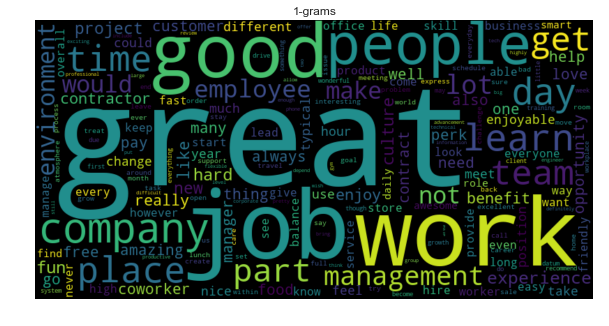

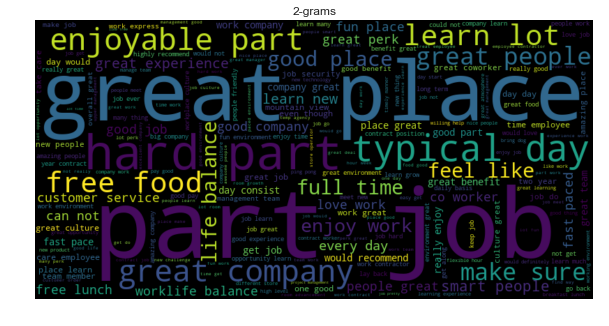

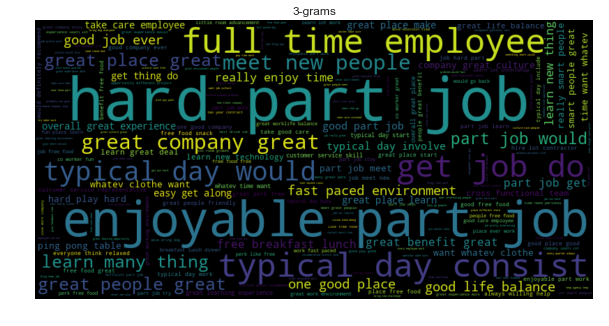

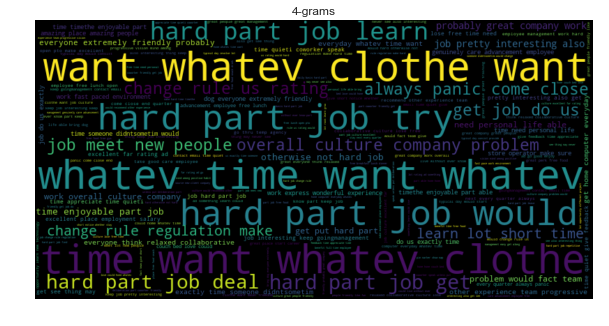

In [55]:
# Wordcloud for 1,2,3,4 grams - google

# Week 3 Text Analytics - Dr. Nathan George

for n in [1, 2, 3, 4]:
    f = wc.generate_from_frequencies(frequencies={w: i for w, i in zip(ngrams_google[n], ngram_counts_google[n])})
    fig = plt.figure(figsize=(10, 10))
    _ = plt.imshow(f, interpolation='bilinear')
    _ = plt.axis("off")  # assign result to a dummy variable so it doesn't show anything
    _ = plt.title(str(n) + '-grams')

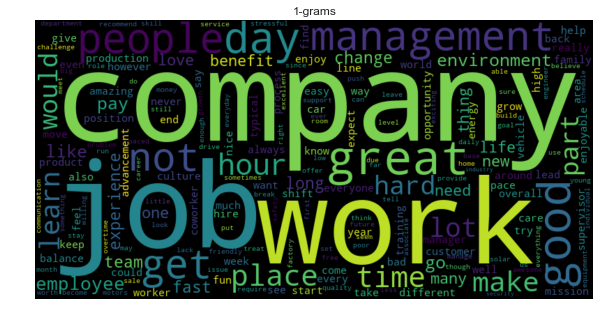

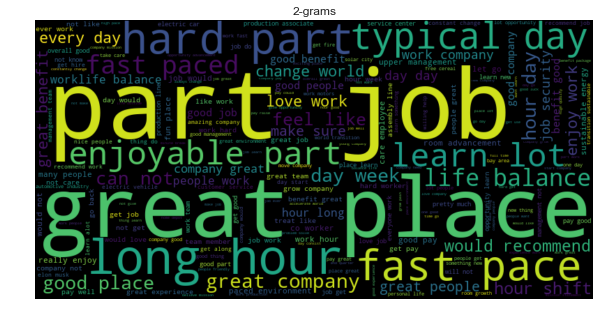

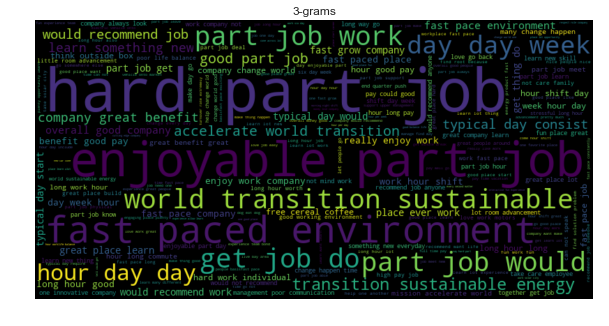

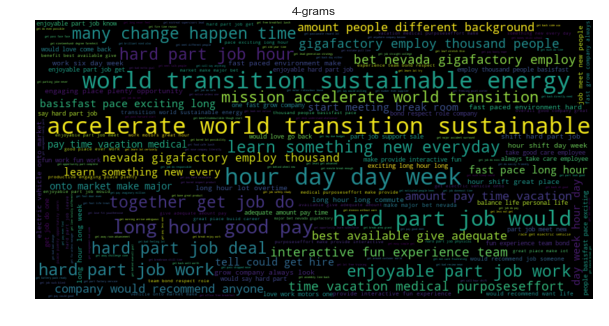

In [56]:
# Wordcloud for 1,2,3,4 grams - tesla

for n in [1, 2, 3, 4]:
    f = wc.generate_from_frequencies(frequencies={w: i for w, i in zip(ngrams_tesla[n], ngram_counts_tesla[n])})
    fig = plt.figure(figsize=(10, 10))
    _ = plt.imshow(f, interpolation='bilinear')
    _ = plt.axis("off")  # assign result to a dummy variable so it doesn't show anything
    _ = plt.title(str(n) + '-grams')

## Time Series

In [57]:
# Value counts by date

# Code Source
# https://stackoverflow.com/questions/22391433/
# count-the-frequency-that-a-value-occurs-in-a-dataframe-column

df_date_count_google = df_google['date'].value_counts()
df_date_count_tesla = df_tesla['date'].value_counts()


In [58]:
# Save as a dataframe
df_date_google = pd.DataFrame(df_date_count_google)
df_date_tesla = pd.DataFrame(df_date_count_tesla)

In [59]:
df_date_google.head()

,date
2018-06-27,6
2017-08-31,6
2018-01-18,6
2018-01-25,5
2018-10-22,5


In [60]:
# Getting into format for time series plot
# reset and name index, rename columns

# Code Source
# https://stackoverflow.com/questions/26097916/
# convert-pandas-series-to-dataframe

df_count_google = df_date_google.date.to_frame().reset_index()
df_count_google = df_count_google.rename(columns= {'index': 'date', 'date': 'count' })
df_count_google.index.name = 'index'

df_count_tesla = df_date_tesla.date.to_frame().reset_index()
df_count_tesla = df_count_tesla.rename(columns= {'index': 'date', 'date': 'count' })
df_count_tesla.index.name = 'index'


In [61]:
df_count_google.head(2)

,date,count
index,,
0,2018-06-27,6
1,2017-08-31,6


In [62]:
# Set date as the index for time series plots

# Code Source - # https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial

df_count_google.set_index('date', inplace=True)
df_count_tesla.set_index('date', inplace=True)

In [63]:
df_count_google.head(2)

,count
date,
2018-06-27,6
2017-08-31,6


In [64]:
# Code Source
# https://stackoverflow.com/questions/38792122/how-to-group-and-count-rows-by-month-and-year-using-pandas

df_count_google = df_count_google.resample('MS').size()
df_count_tesla = df_count_tesla.resample('MS').size()

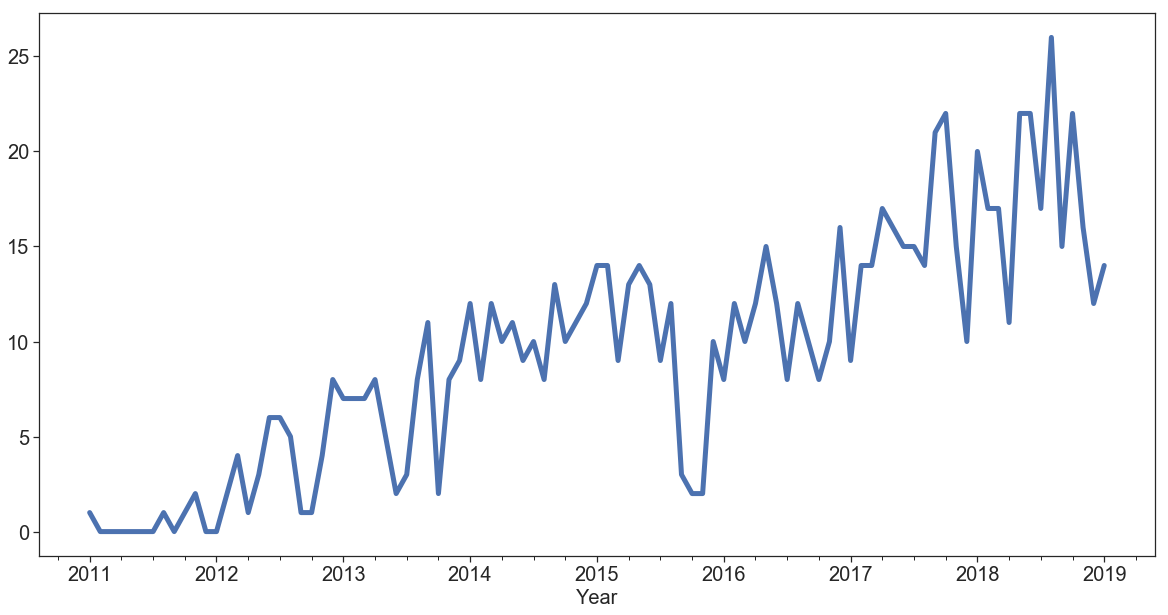

In [65]:
# Plot time series google

# Code Source - 
# https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial

df_count_google.plot(figsize=(20,10),linewidth = 5,fontsize=20)
plt.xlabel('Year',fontsize=20);


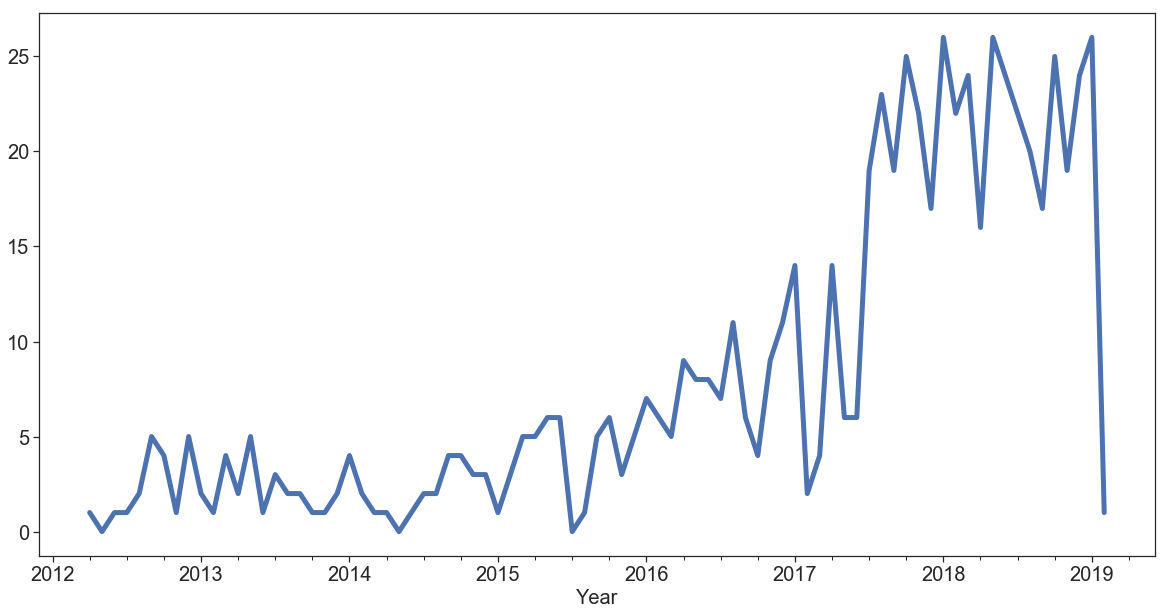

In [66]:
# Plot time series tesla
df_count_tesla.plot(figsize=(20,10),linewidth = 5,fontsize=20)
plt.xlabel('Year',fontsize=20);

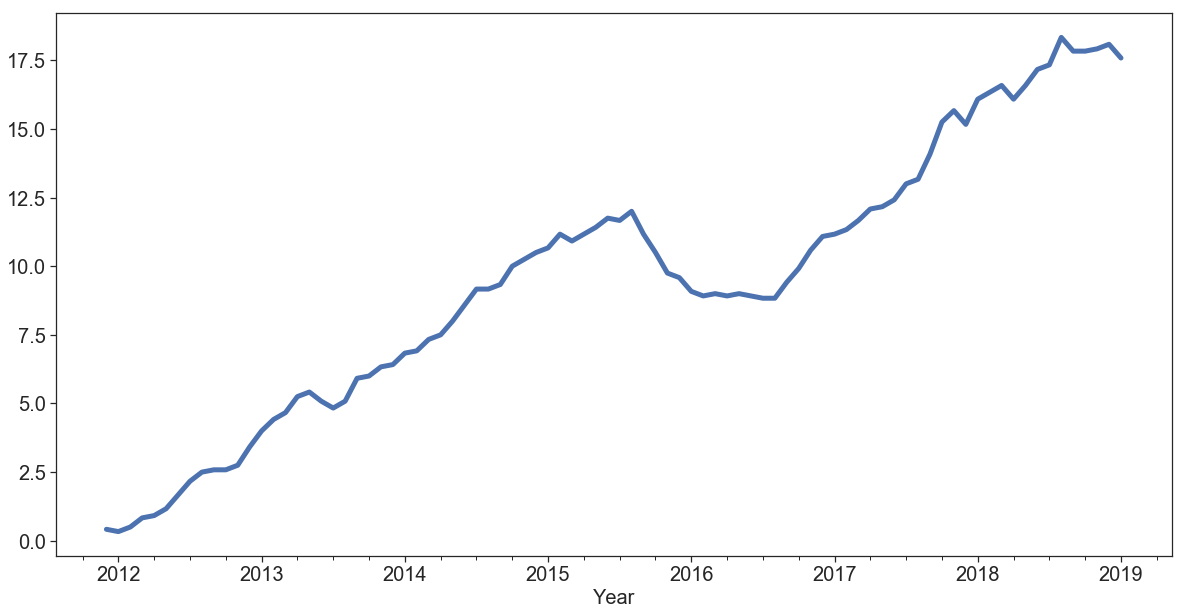

In [67]:
# Plot time series rolling mean google

# Code Source - 
# https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial

df_count_google.rolling(12).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

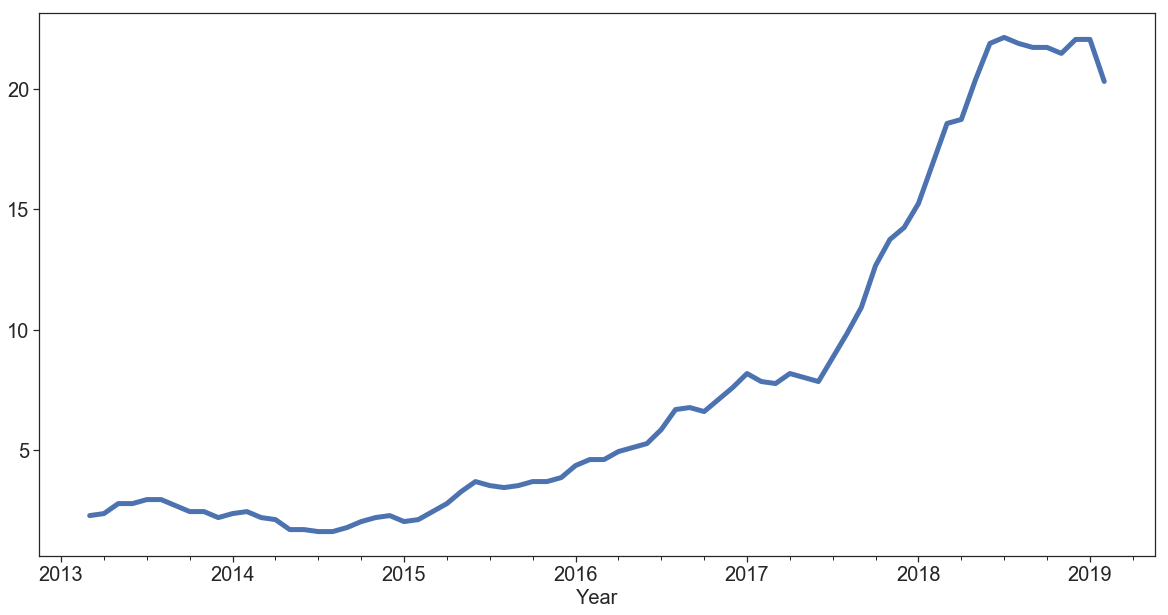

In [68]:
# Plot time series rolling mean tesla

df_count_tesla.rolling(12).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

In [69]:
# Look at day of week reviews were submitted

# Covert to day of the week (Monday=0, Sunday=6)

# Code Source
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.dayofweek.html

df_google_day_of_week = df_comp['date'].dt.dayofweek

In [70]:
# Case statement to match integer to day of week text

# Code Source
# https://data-flair.training/blogs/python-switch-case/

def week(i):
    switcher={
        0:'Monday',
        1:'Tuesday',
        2:'Wednesday',
        3:'Thursday',
        4:'Friday',
        5:'Saturday',
        6:'Sunday'
             }
    return switcher.get(i,"Invalid day of week")

In [71]:
# Creating file to plot day of week by company comparison

# Call function - add new variable to df_comp
df_comp['dayofweek'] = np.array([week(i) for i in df_google_day_of_week[0:]])

In [72]:
# Change data type for categorical variables
df_comp['dayofweek'] = df_comp['dayofweek'].astype('category')

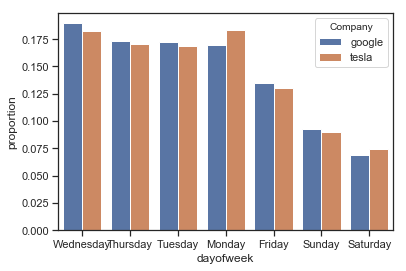

In [73]:
# Barplot - review day of week by company

# Code Source
# https://stackoverflow.com/questions/35692781/python-plotting-percentage-in-seaborn-bar-plot

x, y, hue = "dayofweek", "proportion", "Company"

(df_comp[x]
 .groupby(df_comp[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data",), x=x, y=y, hue=hue,));


## Sentiment Analysis

In [74]:
# Grab reviews variable

# Code source:
# https://dev.to/rodolfoferro/sentiment-analysis-on-trumpss-tweets-using-python-

df_google_cln_rev = pd.DataFrame(data=cln_review_google, columns=['Reviews'])
df_tesla_cln_rev = pd.DataFrame(data=cln_review_tesla, columns=['Reviews'])

In [75]:
# Using textblob for sentiment,
# assign 1, 0, -1 based on polarity

# Code source:
# https://dev.to/rodolfoferro/sentiment-analysis-on-trumpss-tweets-using-python-

def analize_sentiment(Reviews):
   
    analysis = TextBlob(Reviews)
    if analysis.sentiment.polarity >= .3:
        return 1
    elif analysis.sentiment.polarity < .3 and analysis.sentiment.polarity >= -.3 :
        return 0
    else:
        return -1

In [76]:
# Call function and add SA to dataframe

# Code source
# https://dev.to/rodolfoferro/sentiment-analysis-on-trumpss-tweets-using-python-

df_google['SA'] = np.array([analize_sentiment(Reviews) for Reviews in df_google_cln_rev['Reviews']])
df_tesla['SA'] = np.array([analize_sentiment(Reviews) for Reviews in df_tesla_cln_rev['Reviews']])

In [77]:
# Save out polarity to dataframe as well

def analize_polarity(Reviews):
   
    analysis = TextBlob(Reviews)
    return analysis.sentiment.polarity

In [78]:
df_google['Polarity'] = np.array([analize_polarity(Reviews) for Reviews in df_google_cln_rev['Reviews']])
df_tesla['Polarity'] = np.array([analize_polarity(Reviews) for Reviews in df_tesla_cln_rev['Reviews']])

In [79]:
df_google.head(2)

,title,date,rating,reviews,job_title,emp_status,state,latitude,longitude,Company,SA,Polarity
0,Awesome,2018-01-17,5,Awesome stuff at google if I had to rate it fr...,Camp Counselor,former,MA,42.407211,-71.382437,google,1,0.587143
1,Google is great Bon Apeptit isn’t so great!,2018-08-24,5,Google is a great company and the googler were...,Micro kitchen attendant,former,CA,36.778261,-119.417932,google,0,0.081481


In [80]:
df_tesla.head(2)

,title,date,rating,reviews,job_title,emp_status,state,latitude,longitude,Company,SA,Polarity
0,Stressful,2018-06-14,3,Very tight Schedule.Get to learn a little.Aver...,PV Design Engineer II,current,MA,42.407211,-71.382437,tesla,0,0.009921
1,Looks good on the resume,2019-01-16,3,Tesla asks if you're okay with overtime but yo...,Service Advisor,former,CA,36.778261,-119.417932,tesla,0,0.000000


In [81]:
# Look at sentiment compared to rating

# Code Source
# https://pbpython.com/pandas-crosstab.html

pd.crosstab(df_google.rating, df_google.SA)

SA,-1,0,1
rating,,,
1,5,24,6
2,3,29,18
3,2,118,68
4,7,200,161
5,4,296,388


In [82]:
pd.crosstab(df_tesla.rating, df_tesla.SA)

SA,-1,0,1
rating,,,
1,10,89,17
2,8,107,18
3,7,200,64
4,0,194,145
5,2,191,183


In [83]:
# Look at some reviews with positive sentiment and give a rating of 1
# https://stackoverflow.com/questions/17071871/select-rows-from-a-dataframe-based-on-values-in-a-column-in-pandas

df_tesla[['reviews','Polarity']].loc[(df_tesla['rating'] == 1) & (df_tesla['SA'] == 1)].head(5)

,reviews,Polarity
141,The culture of working with this company is th...,0.400000
169,Same as every other tech company now. They wil...,0.500000
290,Depending on where you are in your career this...,0.662500
291,Very long hoursNo career advancementLow salary...,0.341667
348,They hire managers(service managers) with abso...,0.408333


In [84]:
# Check out how textblob is determing sentiment - idea from Dr. George
t = TextBlob('Same as every other tech company now. They will only pay the top people what they want then the rest are left to pick up the pieces. Tesla name carries weight and they know it.')

In [85]:
# Tried to play with sentiment ranges above to improve accuracy, really need to train sentiment model
t.sentiment_assessments

Sentiment(polarity=0.075, subjectivity=0.4, assessments=[(['same'], 0.0, 0.125, None), (['other'], -0.125, 0.375, None), (['only'], 0.0, 1.0, None), (['top'], 0.5, 0.5, None), (['left'], 0.0, 0.0, None)])

## Geo

In [86]:
# Create files with state/sentiment mean and state/rating mean

# Code Source
# https://towardsdatascience.com/pandas-tips-and-tricks-33bcc8a40bb9

df_google_state_SA = df_google.groupby('state')['SA'].mean()
df_tesla_state_SA = df_tesla.groupby('state')['SA'].mean()

df_google_state_rating = df_google.groupby('state')['rating'].mean()
df_tesla_state_rating = df_tesla.groupby('state')['rating'].mean()

In [87]:
# Make them dataframes 

df_google_state_SA = pd.DataFrame(df_google_state_SA)
df_tesla_state_SA = pd.DataFrame(df_tesla_state_SA)

df_google_state_rating = pd.DataFrame(df_google_state_rating)
df_tesla_state_rating = pd.DataFrame(df_tesla_state_rating)

In [88]:
# Reset indexes

df_google_state_SA.reset_index(inplace=True)
df_tesla_state_SA.reset_index(inplace=True)

df_google_state_rating.reset_index(inplace=True)
df_tesla_state_rating.reset_index(inplace=True)

In [89]:
# Remove the ERR states

# https://stackoverflow.com/questions/34397982/pandas-dataframe-access-multiple-items-with-not-equal-to
notERR_google_SA = df_google_state_SA[df_google_state_SA['state'] != 'ERR']
notERR_tesla_SA = df_tesla_state_SA[df_tesla_state_SA['state'] != 'ERR']

# https://stackoverflow.com/questions/34397982/pandas-dataframe-access-multiple-items-with-not-equal-to
notERR_google_rating = df_google_state_rating[df_google_state_rating['state'] != 'ERR']
notERR_tesla_rating = df_tesla_state_rating[df_tesla_state_rating['state'] != 'ERR']

In [90]:
# Looks good!
notERR_google_SA.head()

,state,SA
0,AL,0.000000
1,AR,1.000000
2,AZ,0.333333
3,CA,0.491256
4,CO,0.583333


In [91]:
# Folium choropleth of average sentiment by state - Google

# Code sources
# https://medium.com/@austinlasseter/using-folium-to-generate-a-simple-map-of-your-pandas-data-87ddc5d55f8d
# https://python-graph-gallery.com/292-choropleth-map-with-folium/
# https://github.com/bradtraversy/python_folium_example/edit/master/data/us-states.json

map = folium.Map(location=[48, -102], zoom_start=3)

#mac
state_geo = os.path.join('/Users/christiandavies/Desktop/data_pract_1/Project', 'us-states.json')

# windows 
# state_geo = os.path.join(r"C:\Users\Czdavies\Desktop\DS_prac_1\project", 'us-states.json')

map.choropleth(geo_data=state_geo, data=notERR_google_SA,
             columns=['state', 'SA'],
             key_on='feature.id',
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Sentiment')

map


/Users/christiandavies/anaconda3/lib/python3.6/site-packages/folium/folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [94]:
# Folium choropleth of average rating by state - Google

map = folium.Map(location=[48, -102], zoom_start=3)

map.choropleth(geo_data=state_geo, data=notERR_google_rating,
             columns=['state', 'rating'],
             key_on='feature.id',
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Rating')

map

/Users/christiandavies/anaconda3/lib/python3.6/site-packages/folium/folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [92]:
# Folium choropleth of average sentiment by state - Tesla


map = folium.Map(location=[48, -102], zoom_start=3)

map.choropleth(geo_data=state_geo, data=notERR_tesla_SA,
             columns=['state', 'SA'],
             key_on='feature.id',
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Sentiment')

map


/Users/christiandavies/anaconda3/lib/python3.6/site-packages/folium/folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [93]:
# Folium choropleth of average rating by state - Tesla

map = folium.Map(location=[48, -102], zoom_start=3)

map.choropleth(geo_data=state_geo, data=notERR_tesla_rating,
             columns=['state', 'rating'],
             key_on='feature.id',
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Rating')

map


/Users/christiandavies/anaconda3/lib/python3.6/site-packages/folium/folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## Unsupervised Learning - Clustering

In [125]:
# Convert additional features for machine learning

#df_google_emp_status = pd.get_dummies(df_google['emp_status'])
#df_tesla_emp_status = pd.get_dummies(df_tesla['emp_status'])


In [129]:
# Convert tfidf to dataframe

# Code source
# https://stackoverflow.com/questions/36967666/transform-scipy-sparse-csr-to-pandas

df_tfidf_google = pd.DataFrame(train_tfidf_vectors_google.toarray())
df_tfidf_tesla = pd.DataFrame(train_tfidf_vectors_tesla.toarray())

In [131]:
## Can't use - not getting accurate optimal # of clusters, just going to use TF-IDF

# Concatenate features to one dataframe

df_med_google = pd.concat([df_google.rating, df_google_emp_status, df_tfidf_google], axis=1, ignore_index=True) 
df_med_google = df_med_google.rename(columns= {0: 'rating', 1: 'current', 2: 'former' })


df_med_tesla = pd.concat([df_tesla.rating, df_tesla_emp_status, df_tfidf_tesla], axis=1, ignore_index=True) 
df_med_tesla = df_med_tesla.rename(columns= {0: 'rating', 1: 'current', 2: 'former'})



In [99]:
# Convert to array for lsa
# google_array = np.asarray(df_med_google)
# tesla_array = np.asarray(df_med_tesla)

In [100]:
# LSA feature reduction - going with 100 components - google
# Using feature reduction because pyclustering ran too long

#Code source:
# https://github.com/chrisjmccormick/LSA_Classification/blob/master/inspect_LSA.py
# https://towardsdatascience.com/2-latent-methods-for-dimension-reduction-and-topic-modeling-20ff6d7d547

svd_google = TruncatedSVD(400)
lsa_google = make_pipeline(svd_google, Normalizer(copy=False))
x_train_lsa_google = lsa_google.fit_transform(train_tfidf_vectors_google)
print('LSA output shape:', x_train_lsa_google.shape)
explained_variance_google = svd_google.explained_variance_ratio_.sum()
print("Sum of explained variance ratio: %d%%" % (int(explained_variance_google * 100)))

LSA output shape: (1329, 400)
Sum of explained variance ratio: 78%


In [101]:
# LSA feature reduction - going with 100 components - tesla

svd_tesla = TruncatedSVD(400)
lsa_tesla = make_pipeline(svd_tesla, Normalizer(copy=False))
x_train_lsa_tesla = lsa_tesla.fit_transform(train_tfidf_vectors_tesla)
print('LSA output shape:', x_train_lsa_tesla.shape)
explained_variance_tesla = svd_tesla.explained_variance_ratio_.sum()
print("Sum of explained variance ratio: %d%%" % (int(explained_variance_tesla * 100)))

LSA output shape: (1235, 400)
Sum of explained variance ratio: 79%


In [109]:
# google - pyclustering silhouette - min clusters 2, max clusters 100
# Did not run for github, went with 17 clusters from previous runs

# Code source
# https://codedocs.xyz/annoviko/pyclustering/classpyclustering_1_1cluster_1_1silhouette_1_1silhouette__ksearch.html

search_instance = silhouette_ksearch(x_train_lsa_google,2,100, algorithm=silhouette_ksearch_type.KMEDOIDS).process()
amount = search_instance.get_amount()
scores = search_instance.get_scores()
print("Scores: '%s'" % str(scores))

In [110]:
# google - Get index of max score - identify optimal # of clusters

# Code source
# https://stackoverflow.com/questions/268272/getting-key-with-maximum-value-in-dictionary

max(scores.items(), key=operator.itemgetter(1))[0]

In [ ]:
# tesla - pyclustering silhouette - min clusters 2, max clusters 50
# Did not run for github, went with 17 clusters from previous runs

search_instance = silhouette_ksearch(x_train_lsa_tesla,2,30, algorithm=silhouette_ksearch_type.KMEDOIDS).process()
amount = search_instance.get_amount()
scores = search_instance.get_scores()
print("Scores: '%s'" % str(scores))

In [ ]:
# tesla - Get index of max score - identify optimal # of clusters

max(scores.items(), key=operator.itemgetter(1))[0]

In [132]:
# tolist needed for k-medoids
google_list = df_med_google.values.tolist()
tesla_list = df_med_tesla.values.tolist()

In [133]:
# google - Kmedoids - with optimal clusters

# Code source
# https://github.com/annoviko/pyclustering/blob/master/pyclustering/cluster/ema.py
# https://github.com/annoviko/pyclustering/issues/366
# https://codedocs.xyz/annoviko/pyclustering/classpyclustering_1_1cluster_1_1kmedoids_1_1kmedoids.html
# https://github.com/letiantian/kmedoids

# set random initial medoids
initial_medoids_google = list(range(0,17))

# create instance of K-Medoids algorithm
kmedoids_instance_google = kmedoids(google_list, initial_medoids_google)

# run cluster analysis and obtain results
kmedoids_instance_google.process();
clusters_google = kmedoids_instance_google.get_clusters()
medoids_google = kmedoids_instance_google.get_medoids();

print("Amount of clusters - Google:", len(clusters_google));
for cluster in clusters_google:
    print("Cluster length:", len(cluster));

Amount of clusters - Google: 17
Cluster length: 44
Cluster length: 113
Cluster length: 35
Cluster length: 12
Cluster length: 62
Cluster length: 43
Cluster length: 22
Cluster length: 36
Cluster length: 329
Cluster length: 96
Cluster length: 144
Cluster length: 124
Cluster length: 78
Cluster length: 38
Cluster length: 83
Cluster length: 46
Cluster length: 24


In [134]:
# tesla - Kmedoids - with optimal clusters 

# set random initial medoids
initial_medoids_tesla = list(range(0,17))

# create instance of K-Medoids algorithm
kmedoids_instance_tesla = kmedoids(tesla_list, initial_medoids_tesla)

# run cluster analysis and obtain results
kmedoids_instance_tesla.process();
clusters_tesla = kmedoids_instance_tesla.get_clusters()
medoids_tesla = kmedoids_instance_tesla.get_medoids();

print("Amount of clusters - Tesla:", len(clusters_tesla));
for cluster in clusters_tesla:
    print("Cluster length:", len(cluster));

Amount of clusters - Tesla: 17
Cluster length: 116
Cluster length: 74
Cluster length: 1
Cluster length: 80
Cluster length: 20
Cluster length: 63
Cluster length: 44
Cluster length: 54
Cluster length: 61
Cluster length: 37
Cluster length: 233
Cluster length: 142
Cluster length: 38
Cluster length: 72
Cluster length: 22
Cluster length: 142
Cluster length: 36


In [171]:
# google - Create a file with cluster and original index of cluster

# Code from Dr. George

cluster_number_google = []
indices_google = []
for i, c in enumerate(clusters_google):
    cluster_number_google.extend([i] * len(c))
    indices_google.extend(c)

df_google_cluster = pd.DataFrame({'cluster': cluster_number_google, 'index': indices_google})

In [172]:
# tesla - Create a file with cluster and original index of cluster

# Code from Dr. George

cluster_number_tesla = []
indices_tesla = []
for i, c in enumerate(clusters_tesla):
    cluster_number_tesla.extend([i] * len(c))
    indices_tesla.extend(c)

df_tesla_cluster = pd.DataFrame({'cluster': cluster_number_tesla, 'index': indices_tesla})

In [173]:
df_google_cluster.head()

,cluster,index
0,0,0
1,0,24
2,0,26
3,0,93
4,0,97


In [174]:
# Line up indexes and add cluster to original dataframes

df_google_cluster.set_index('index', inplace=True)
df_tesla_cluster.set_index('index', inplace=True)

df_google_cluster.sort_index(inplace=True)
df_tesla_cluster.sort_index(inplace=True)

df_med_google['cluster'] = df_google_cluster['cluster']
df_med_tesla['cluster'] = df_tesla_cluster['cluster']

In [175]:
df_med_google.head(2)

,rating,current,former,3,4,5,6,7,8,9,...,1463,1464,1465,1466,1467,1468,1469,1470,1471,cluster
0,5,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
1,5,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.246606,0.0,0.0,0.0,0.0,0.0,0.0,1


In [176]:
# Group by cluster and capture mean of each variable

#Code source
# https://stackoverflow.com/questions/30328646/python-pandas-group-by-in-group-by-and-average

df_grouped_google = df_med_google.groupby(['cluster']).mean()
df_grouped_tesla = df_med_tesla.groupby(['cluster']).mean()

In [177]:
# Drop some columns not needed for cluster analysis

df_grouped_google.drop(['rating','current','former'], inplace=True, axis=1)
df_grouped_tesla.drop(['rating','current','former'], inplace=True, axis=1)

In [178]:
# Going to re-use countvectorizer, grabbing the clean reviews used earlier

df_google_cluster_words = pd.DataFrame(cln_review_google)
df_tesla_cluster_words = pd.DataFrame(cln_review_tesla)

In [179]:
# Lining up the assigned cluster with each review

df_google_cluster_words['cluster'] = df_google_cluster['cluster']
df_tesla_cluster_words['cluster'] = df_tesla_cluster['cluster']

In [180]:
df_google_cluster_words.head()

,0,cluster
0,awesome stuff rate would def great company cul...,0
1,great company googler awesome knowledgeable op...,1
2,management low regard anyone come contractor l...,2
3,smart colleague amazing tool great perk move f...,3
4,work contract agency randstad poor management ...,4


In [181]:
# Which google clusters have the highest total average tfidf
df_google_summed = df_grouped_google.sum(axis=1)
df_google_summed.sort_values(ascending=False)

cluster
14    4.348826
15    4.195051
4     4.192854
9     4.097194
5     4.073365
7     4.057541
0     4.006734
11    3.974608
6     3.961718
10    3.871068
16    3.856995
2     3.829380
13    3.817492
8     3.798637
3     3.754313
12    3.649465
1     3.368795
dtype: float64

In [182]:
# Which tesla clusters have the highest total average tfidf
df_tesla_summed = df_grouped_tesla.sum(axis=1)
df_tesla_summed.sort_values(ascending=False)

cluster
8     4.695051
2     4.627293
6     4.561097
14    4.434510
13    4.403876
16    4.378338
12    4.375590
3     4.361190
15    4.136713
5     4.083817
1     4.071658
0     4.033250
11    4.019286
10    3.994251
7     3.933792
4     3.827699
9     3.681930
dtype: float64

In [183]:
# Google top 3 clusters - filter records for top clusters into their own file
first_google_cluster = df_google_cluster_words.loc[df_google_cluster_words['cluster'] == 14]
second_google_cluster = df_google_cluster_words.loc[df_google_cluster_words['cluster'] == 15]
third_google_cluster = df_google_cluster_words.loc[df_google_cluster_words['cluster'] == 4]

In [184]:
# Tesla top 3 clusters - filter records for top clusters into their own file
first_tesla_cluster = df_tesla_cluster_words.loc[df_tesla_cluster_words['cluster'] == 8]
second_tesla_cluster = df_tesla_cluster_words.loc[df_tesla_cluster_words['cluster'] == 2]
third_tesla_cluster = df_tesla_cluster_words.loc[df_tesla_cluster_words['cluster'] == 6]

In [185]:
# Drop the cluster variable to count words
first_google_cluster.drop(columns = 'cluster', inplace=True, axis=1)
second_google_cluster.drop(columns = 'cluster', inplace=True, axis=1)
third_google_cluster.drop(columns = 'cluster', inplace=True, axis=1)

first_tesla_cluster.drop(columns = 'cluster', inplace=True, axis=1)
second_tesla_cluster.drop(columns = 'cluster', inplace=True, axis=1)
third_tesla_cluster.drop(columns = 'cluster', inplace=True, axis=1)

/Users/christiandavies/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/christiandavies/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/christiandavies/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removin

In [186]:
# Make lists for countvectorizer
first_google_cluster_list = first_google_cluster.values.tolist()
second_google_cluster_list = second_google_cluster.values.tolist()
third_google_cluster_list = third_google_cluster.values.tolist()

first_tesla_cluster_list = first_tesla_cluster.values.tolist()
second_tesla_cluster_list = second_tesla_cluster.values.tolist()
third_tesla_cluster_list = third_tesla_cluster.values.tolist()

In [187]:
# Google cluster 14
# Report out top 10 for 1,2,3, and 4 grams
# This run slightly different that results in presentation

ngrams_google, ngram_counts_google = {}, {}

first_google_cluster = [str(first_google_cluster_list)]

print ('Cluster 14')

for n in [1, 2, 3, 4]:
    print('top 10', str(n) + '-grams:\n')
    ngrams_google[n], ngram_counts_google[n] = get_top_grams_google(first_google_cluster, n=n)
    print('\n')

Cluster 14
top 10 1-grams:

"job" shows up 44 times
"time" shows up 36 times
"work" shows up 29 times
"management" shows up 26 times
"part" shows up 25 times
"great" shows up 25 times
"get" shows up 22 times
"team" shows up 22 times
"contractor" shows up 22 times
"would" shows up 21 times


top 10 2-grams:

"part job" shows up 10 times
"typical day" shows up 9 times
"hard part" shows up 7 times
"enjoyable part" shows up 7 times
"great place" shows up 5 times
"mountain view" shows up 4 times
"make sure" shows up 4 times
"team member" shows up 3 times
"would also" shows up 3 times
"full time" shows up 3 times


top 10 3-grams:

"hard part job" shows up 5 times
"enjoyable part job" shows up 3 times
"san bruno youtube" shows up 2 times
"make sure customer" shows up 2 times
"typical day would" shows up 2 times
"meeting default minute" shows up 2 times
"full time employee" shows up 2 times
"fulfillment team responsible" shows up 1 times
"fulfillment correctly time" shows up 1 times
"full aut

In [188]:
# Google cluster 15
# Report out top 10 for 1,2,3, and 4 grams

ngrams_google, ngram_counts_google = {}, {}

print ('Cluster 1')

second_google_cluster = [str(second_google_cluster_list)]

for n in [1, 2, 3, 4]:
    print('top 15', str(n) + '-grams:\n')
    ngrams_google[n], ngram_counts_google[n] = get_top_grams_google(second_google_cluster, n=n)
    print('\n')

Cluster 1
top 15 1-grams:

"job" shows up 39 times
"day" shows up 33 times
"part" shows up 30 times
"learn" shows up 22 times
"time" shows up 20 times
"hard" shows up 20 times
"make" shows up 18 times
"good" shows up 17 times
"work" shows up 17 times
"people" shows up 16 times


top 15 2-grams:

"hard part" shows up 14 times
"part job" shows up 12 times
"typical day" shows up 9 times
"enjoyable part" shows up 5 times
"day consist" shows up 4 times
"good job" shows up 3 times
"day would" shows up 3 times
"make sure" shows up 3 times
"job get" shows up 3 times
"store operator" shows up 3 times


top 15 3-grams:

"hard part job" shows up 6 times
"typical day consist" shows up 3 times
"enjoyable part job" shows up 2 times
"enjoyable part work" shows up 2 times
"part job get" shows up 2 times
"go home feel" shows up 1 times
"go much fasterand" shows up 1 times
"get may pay" shows up 1 times
"get response problemsolv" shows up 1 times
"get right gathering" shows up 1 times


top 15 4-grams:


In [189]:
# Google cluster 4
# Report out top 10 for 1,2,3, and 4 grams

ngrams_google, ngram_counts_google = {}, {}

print ('Cluster 4')

third_google_cluster = [str(third_google_cluster_list)]

for n in [1, 2, 3, 4]:
    print('top 10', str(n) + '-grams:\n')
    ngrams_google[n], ngram_counts_google[n] = get_top_grams_google(third_google_cluster, n=n)
    print('\n')

Cluster 4
top 10 1-grams:

"day" shows up 36 times
"work" shows up 33 times
"management" shows up 24 times
"job" shows up 24 times
"team" shows up 21 times
"get" shows up 21 times
"good" shows up 18 times
"customer" shows up 14 times
"project" shows up 13 times
"free" shows up 13 times


top 10 2-grams:

"typical day" shows up 9 times
"part job" shows up 4 times
"hard part" shows up 4 times
"management team" shows up 4 times
"enjoy every" shows up 3 times
"one day" shows up 3 times
"every day" shows up 3 times
"day consist" shows up 3 times
"overall great" shows up 3 times
"day start" shows up 3 times


top 10 3-grams:

"hard part job" shows up 3 times
"care advancement employee" shows up 2 times
"make excellent place" shows up 2 times
"open pto make" shows up 2 times
"genuinely care advancement" shows up 2 times
"enjoy every minute" shows up 2 times
"advancement employee free" shows up 2 times
"get job do" shows up 2 times
"cross functional team" shows up 2 times
"employee free lunch"

In [190]:
# Tesla cluster 8
# Report out top 10 for 1,2,3, and 4 grams

ngrams_tesla, ngram_counts_tesla = {}, {}

first_tesla_cluster = [str(first_tesla_cluster_list)]

print ('Cluster 8')

for n in [1, 2, 3, 4]:
    print('top 10', str(n) + '-grams:\n')
    ngrams_tesla[n], ngram_counts_tesla[n] = get_top_grams_tesla(first_tesla_cluster, n=n)
    print('\n')

Cluster 8
top 10 1-grams:

"management" shows up 36 times
"company" shows up 29 times
"not" shows up 29 times
"people" shows up 28 times
"get" shows up 26 times
"job" shows up 23 times
"lot" shows up 20 times
"time" shows up 20 times
"go" shows up 19 times
"great" shows up 18 times


top 10 2-grams:

"life balance" shows up 7 times
"can not" shows up 4 times
"treat like" shows up 3 times
"great place" shows up 3 times
"come go" shows up 3 times
"lose job" shows up 3 times
"good place" shows up 3 times
"get pass" shows up 2 times
"need job" shows up 2 times
"multiple time" shows up 2 times


top 10 3-grams:

"employee come go" shows up 2 times
"yourre target warehouse" shows up 1 times
"great people demand" shows up 1 times
"great product culture" shows up 1 times
"great potential nearly" shows up 1 times
"great place provide" shows up 1 times
"great place pomona" shows up 1 times
"great place great" shows up 1 times
"great people overwhelming" shows up 1 times
"great not allow" shows u

In [191]:
# Tesla cluster 2
# Report out top 10 for 1,2,3, and 4 grams

ngrams_tesla, ngram_counts_tesla = {}, {}

second_tesla_cluster = [str(second_tesla_cluster_list)]

print ('Cluster 2')

for n in [1, 2, 3, 4]:
    print('top 10', str(n) + '-grams:\n')
    ngrams_tesla[n], ngram_counts_tesla[n] = get_top_grams_tesla(second_tesla_cluster, n=n)
    print('\n')

Cluster 2
top 10 1-grams:

"great" shows up 6 times
"job" shows up 3 times
"model" shows up 3 times
"go" shows up 3 times
"love" shows up 3 times
"back" shows up 2 times
"experience" shows up 2 times
"would" shows up 2 times
"part" shows up 1 times
"feature" shows up 1 times


top 10 2-grams:

"would love" shows up 2 times
"great experience" shows up 2 times
"go back" shows up 2 times
"experience whole" shows up 1 times
"great job" shows up 1 times
"great environment" shows up 1 times
"great benefit" shows up 1 times
"go man" shows up 1 times
"future great" shows up 1 times
"feature way" shows up 1 times


top 10 3-grams:

"would love go" shows up 1 times
"help build model" shows up 1 times
"great job security" shows up 1 times
"great experience whole" shows up 1 times
"great experience help" shows up 1 times
"great environment career" shows up 1 times
"great benefit list" shows up 1 times
"go man like" shows up 1 times
"go back permanently" shows up 1 times
"future great benefit" show

In [192]:
# Tesla cluster 6
# Report out top 10 for 1,2,3, and 4 grams

ngrams_tesla, ngram_counts_tesla = {}, {}

third_tesla_cluster = [str(third_tesla_cluster_list)]

print ('Cluster 6')

for n in [1, 2, 3, 4]:
    print('top 10', str(n) + '-grams:\n')
    ngrams_tesla[n], ngram_counts_tesla[n] = get_top_grams_tesla(third_tesla_cluster, n=n)
    print('\n')

Cluster 6
top 10 1-grams:

"job" shows up 39 times
"day" shows up 37 times
"part" shows up 29 times
"management" shows up 18 times
"company" shows up 17 times
"work" shows up 17 times
"learn" shows up 15 times
"time" shows up 14 times
"good" shows up 14 times
"team" shows up 14 times


top 10 2-grams:

"part job" shows up 17 times
"hard part" shows up 10 times
"enjoyable part" shows up 9 times
"typical day" shows up 8 times
"next day" shows up 4 times
"fast paced" shows up 4 times
"people work" shows up 3 times
"part day" shows up 3 times
"day start" shows up 3 times
"job work" shows up 2 times


top 10 3-grams:

"hard part job" shows up 10 times
"enjoyable part job" shows up 5 times
"enjoyable part day" shows up 3 times
"part job learn" shows up 2 times
"part job work" shows up 2 times
"give life mission" shows up 1 times
"get shut try" shows up 1 times
"get start environment" shows up 1 times
"get thing do" shows up 1 times
"give access udemy" shows up 1 times


top 10 4-grams:

"you

## LDA/NMF

In [160]:
# Code Source
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_
# nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [161]:
# Fit the NMF model 1 - google

n_components = 10
n_top_words = 10

nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(train_tfidf_vectors_google)

tfidf_feature_names = tfidf_vectorizer_google.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topic #0: great environment culture perk benefit life atmosphere experience balance growth
Topic #1: job part day hard get enjoyable time typical make management
Topic #2: good balance life could flexible really management pay benefit job
Topic #3: employee contractor not treat time like hire full contract year
Topic #4: learn lot new opportunity experience team project thing different management
Topic #5: company amazing benefit excellent culture grow new like really provide
Topic #6: work enjoy love experience really team wonderful different awesome everyone
Topic #7: people smart meet environment lot amazing really nice benefit much
Topic #8: free food lunch gym awesome snack amazing perk building eat
Topic #9: place fun amazing nice love environment one need management productive



In [162]:
# Fit the NMF model 2 - google
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(train_tfidf_vectors_google)

tfidf_feature_names = tfidf_vectorizer_google.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topic #0: great place time job people get nice management overall culture
Topic #1: job part day typical hard enjoyable time would get learn
Topic #2: good employee could pay care time place one well life
Topic #3: not contractor employee time like year would treat contract work
Topic #4: learn work new team experience lot opportunity use way business
Topic #5: company great part benefit product hour good coworker hard difficult
Topic #6: work job really love enjoy would experience great not people
Topic #7: people lot smart project thing perk many culture much meet
Topic #8: place free make fun food day lunch amazing productive really
Topic #9: environment management team project fun fast open well excellent challenge



In [163]:
# Fit the LDA model 1 - google
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

lda.fit(train_tfidf_vectors_google)

tf_feature_names = tfidf_vectorizer_google.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Topic #0: perfect innovation completely someone company vaco youtube good internal fiber
Topic #1: lean glass machine good tvc guidance financially feedback work job
Topic #2: courier partner bad get look people excellent position benefit great
Topic #3: file upload night gear online high time person release view
Topic #4: believe align not manager function good awesome would incredible employee
Topic #5: feel great place company office good perk enjoy team awesome
Topic #6: produce managed education page property cover east india content enterprise
Topic #7: great work good job company people place learn team environment
Topic #8: not job great good get culture company corporate benefit place
Topic #9: de con key san conversion promise vision door revolve temp



In [164]:
# Fit the NMF model 1 - tesla

n_components = 10
n_top_words = 10

nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(train_tfidf_vectors_tesla)

tfidf_feature_names = tfidf_vectorizer_tesla.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topic #0: not get management like make go job employee would time
Topic #1: great benefit experience overall environment atmosphere lot around advancement management
Topic #2: hour day long week shift pay life time sometimes free
Topic #3: part job hard enjoyable learn day typical easy different lot
Topic #4: company change world mission grow energy amazing new future product
Topic #5: good pay benefit management friendly lot room opportunity overall bad
Topic #6: place nice time opportunity fun make exciting learn employee also
Topic #7: work enjoy love would really recommend like experience fun learn
Topic #8: fast pace environment paced always grow busy lot high think
Topic #9: people fun many learn meet thing amazing culture around friendly



In [165]:
# Fit the NMF model 2 - tesla
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(train_tfidf_vectors_tesla)

tfidf_feature_names = tfidf_vectorizer_tesla.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topic #0: work get would management job make like people company one
Topic #1: great place company good opportunity team learn benefit people experience
Topic #2: hour long time week day pay shift life employee place
Topic #3: part job learn hard day typical team production enjoyable time
Topic #4: management company product well process change poor set environment support
Topic #5: good management people place really supervisor pay job thing get
Topic #6: make thing day pace go get nice time place fast
Topic #7: work company would enjoy good love recommend one experience lot
Topic #8: job fast not environment time paced pace well like lot
Topic #9: people world change mission want hard not young company love



In [166]:
# Fit the LDA model 1 - tesla
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

lda.fit(train_tfidf_vectors_tesla)

tf_feature_names = tfidf_vectorizer_tesla.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Topic #0: day meeting daily six night load fully work coordinate provide
Topic #1: different get manager time fun helpful great amazing people employee
Topic #2: good management pace meet late benefit great like job layoff
Topic #3: last long help hour use service life good place day
Topic #4: limited supervision responsible past production environment company time change great
Topic #5: read electrical house install lay able great job work world
Topic #6: installation access involve responsible solution policy method engineering oversee per
Topic #7: great company good work job place day people management hour
Topic #8: change huge hour people thing long excellence stressful work much
Topic #9: people opportunity thing lot grow good lead much employee career

